In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import ipyvolume as ipv
from ipywidgets import FloatProgress
from IPython.display import display, Image

from tyssue import HistoryHdf5, EventManager

from tyssue.draw import sheet_view, browse_history
from tyssue.geometry.bulk_geometry import ClosedMonolayerGeometry as geom
from tyssue.io import hdf5
from tyssue.dynamics import model_factory, effectors
from tyssue.generation.shapes import spherical_monolayer

from tyssue.behaviors import EventManager
from tyssue.behaviors import increase, decrease, reconnect
from tyssue.solvers.viscous import EulerSolver
from tyssue.utils.decorators import face_lookup


from tyssue.draw import highlight_faces, create_gif
from tyssue.solvers.quasistatic import QSSolver


from tyssue import HistoryHdf5



from pathlib import Path

from tyssue.utils.decorators import cell_lookup
from tyssue.topology.monolayer_topology import cell_division


Reference: https://elifesciences.org/articles/32943


It is conveninent to consider that cells have an average volume of 1


| stade  | nombe de cellules | volume interne (μm3) |
| ------ | --------- | ---------- |
| 3 | 120 | 181008 |
| 4 | 200 | 670400 |
| 5 | 400 | 3352000 | 
| 6 | 700 | 12318600 | 

## Experimental data

In [2]:
growth = pd.DataFrame(
    data=[[12, 181000], [200, 670400], [400, 3352000], [700, 12318600]],
    index=pd.Index([3, 4, 5, 6], name='stage'),
    columns=['Nc', 'lumen_vol']
)
growth

,Nc,lumen_vol
stage,,
3,12,181000
4,200,670400
5,400,3352000
6,700,12318600


$$
\ln(V_\mathrm{lum})(t) = a + k_V t\\
V_\mathrm{lum}(t) = V_0 e^{k_V t}
$$



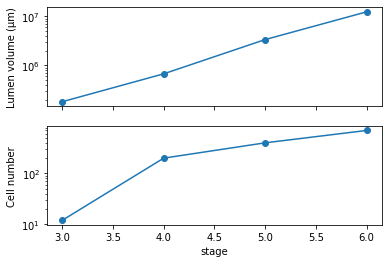

In [3]:
fig, (ax_v, ax_c) = plt.subplots(2, sharex=True)

ax_v.plot(growth.lumen_vol, '-o')
ax_v.set_yscale('log')
ax_v.set_ylabel('Lumen volume (µm)')

ax_c.plot(growth.Nc, '-o')
ax_c.set_yscale('log')
ax_c.set_ylabel('Cell number')
_ = ax_c.set_xlabel("stage")


In [4]:
kV, lnV0 = np.polyfit(growth.index, np.log(growth.lumen_vol), 1)

print(f"Lumen volume growth rate: {kV:.2f}")

kD, lnc0 = np.polyfit(growth.index, np.log(growth.Nc), 1)

print(f"Division rate: {kD:.2f}")


Lumen volume growth rate: 1.43
Division rate: 1.29


## Analytical model


What parameters are needed to have nearly flat cells in the absence of line tension and polarized cells with it?


Let's assume a spherical shell of inner radius $r_a$ and outer radius $r_b$ composed of $N_c$ identical cells.

With surface tension only on apical faces, energy is:

$$
\frac{K_L}{2}(\frac{4\pi}{3}r_a^3 - V^0_L)^2 
+ N_c \left(\frac{K_\mbox{c}}{2}(\frac{4\pi}{3N_c}(r_b^3 - r_a^3) - V^0_c)^2
+ \gamma_a \frac{4\pi}{N_c} r_a^2\right)
$$

We choose the unit length such that $V^0_c = 1$

Here the equilibrium is attained when 

1. the cells reach their equilibrium voume :

$$
\frac{4\pi}{3N_c}(r_b^3 - r_a^3) - 1 = 0
$$

So with $\rho = r_b/r_a$:

$$
r_a = \left(\frac{3N_c}{4\pi (\rho^3 - 1)}\right)^{1/3}
$$

2. Surface tension contraction of the lumen is compensated by lumen elasticity:

$$
\frac{\partial}{\partial r_a}\left(\frac{K_L}{2}(\frac{4\pi}{3}r_a^3 - V^0_L)^2 
+ \gamma_a 4\pi r_a^2)\right) = 0
$$

$$
\begin{eqnarray}
4\pi r_a \left(K_L  r_a (\frac{4\pi}{3}r_a^3 - V^0_L) + 2\gamma_a \right) &=& 0\\
\gamma_a = \frac{K_L r_a}{2} (V_L^0 - \frac{4}{3}\pi r_a^3)
\end{eqnarray}
$$




Without surface tension (i.e. without myosin):

$$
V_L^0 = \frac{4\pi}{3}r_{a,0}^3 = N_c (\rho_0^3 - 1)
$$

We know that without myosin cells are nearly flat, so we can set $\rho_0 = 1.01$.

With myosin, cells are cuboidal, so height is about 1, thus $\rho = 2$.




prefered volume: 549.451


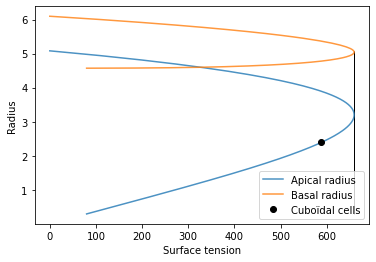

In [5]:
def apical_rad(rho, Nc):
    return (3 * Nc / (4*np.pi*(rho**3 - 1)))**(1/3)


def surface_tension(r_a, Nc, rho0, K_L=1):
    V_L0 = Nc / (rho0**3 - 1)
    return K_L * r_a * (V_L0 - 4 * np.pi * r_a**3 / 3) / 2
    

Nc = 400
rho0 = 1.2

rhos = np.linspace(rho0, 1 + 2*Nc**(1/3), 1000)
V_L0 = Nc / (rho0**3 - 1)
print(f"prefered volume: {V_L0:.3f}")
r_ac = (3 * V_L0 / (16 * np.pi))**(1/3)
gamma_crit = surface_tension(r_ac, Nc, rho0)

r_as = apical_rad(rhos, Nc)
gammas = surface_tension(r_as, Nc, rho0)

rho_cub = 2
r_acub = apical_rad(rho_cub, Nc)
gamma_cub = surface_tension(r_acub, Nc, rho0)

r_bs = r_as * rhos
fig, ax = plt.subplots()

ax.plot(gammas, r_as, '-', label="Apical radius", alpha=0.8, mfc='none')
ax.plot(gammas, r_bs, '-', label="Basal radius", alpha=0.8, mfc='none')
ax.plot(gamma_cub, r_acub, 'ko', label='Cuboïdal cells')
ax.vlines(gamma_crit, r_as.min(), r_as.max(), lw=1)

ax.set_xlabel('Surface tension')
ax.set_ylabel('Radius')

ax.legend();

## Follicle monolayer creation


In [6]:
follicle = spherical_monolayer(9., 12., Nc, apical='in')
follicle.settings["lumen_side"] = "apical"
geom.update_all(follicle)
geom.scale(follicle, follicle.cell_df.vol.mean()**(-1/3), list("xyz"))
geom.update_all(follicle)


for df in follicle.datasets.values():
    df.dropna(axis=1, how='any', inplace=True)

print(f"Follicle has {follicle.Nc} cells")

Follicle has 428 cells


In [7]:
print(follicle.settings)

{'lumen_side': 'apical', 'lumen_vol': 314.76548873703837}


In [8]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}


In [9]:
ipv.clear()
follicle.face_df['visible'] = (follicle.face_df['y'] > 0) | (follicle.face_df['x'] > 0)
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [10]:
bck0 = follicle.copy()

In [11]:
follicle = bck0.copy()

model = model_factory([
    effectors.LumenVolumeElasticity,
    effectors.SurfaceTension,
    effectors.CellVolumeElasticity,
    ])



specs = {
    'cell': {
        'is_alive': 1,
        'vol_elasticity': 100.0,
        'prefered_vol': 1.0
    },
    'face': {
        'is_alive': 1,
        'surface_tension': 10.0,
#        'perimeter_elasticity': 5.,
#        'prefered_perimeter': 3.8,
    },
    'settings': {
        'lumen_vol_elasticity': 1.,
        'lumen_prefered_vol': V_L0,
    }
}

follicle.update_specs(specs, reset=True)



Reseting column is_alive of the cell dataset with new specs
Reseting column is_alive of the face dataset with new specs


In [28]:
# follicle.face_df.loc[follicle.apical_faces, 'perfered_perimeter'] = 0.8*follicle.face_df.loc[follicle.apical_faces, 'perimeter'].mean()
# follicle.face_df.loc[follicle.basal_faces, 'perfered_perimeter'] = 0.8*follicle.face_df.loc[follicle.basal_faces, 'perimeter'].mean()
# follicle.face_df.loc[follicle.lateral_faces, 'perfered_perimeter'] = 0.8*follicle.face_df.loc[follicle.lateral_faces, 'perimeter'].mean()


In [12]:
follicle.settings

{'lumen_side': 'apical',
 'lumen_vol': 314.76548873703837,
 'lumen_vol_elasticity': 1.0,
 'lumen_prefered_vol': 549.4505494505496}

In [13]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)



b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [14]:
ipv.clear()
follicle.face_df['visible'] = (
    (
        (follicle.face_df['y'] > 0)
        | (follicle.face_df['x'] > 0)
    )
    #& (follicle.face_df['segment'] == "apical")
)
# reset full visibility
# follicle.face_df['visible'] = True
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [15]:
r_a = np.linalg.norm(
    follicle.vert_df.loc[follicle.apical_verts, ['x', 'y', 'z']],
    axis=1
)
r_b = np.linalg.norm(
    follicle.vert_df.loc[follicle.basal_verts, ['x', 'y', 'z']],
    axis=1
)
rho = r_b.mean()/r_a.mean()
print(f"rho : {rho: .2f}")
print(f"mean apical radius: {r_a.mean(): .3f}")

rho :  1.13
mean apical radius:  5.094


In [16]:
#follicle.face_df['surface_tension'] = 10.0
follicle.face_df.loc[follicle.apical_faces, 'surface_tension'] = 300.0


In [17]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [18]:
ipv.clear()
follicle.face_df['visible'] = (
    (
        (follicle.face_df['y'] > 0)
        | (follicle.face_df['x'] > 0)
    )
    #& (follicle.face_df['segment'] == "apical")
)
# reset full visibility
# follicle.face_df['visible'] = True
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [19]:
r_a = np.linalg.norm(
    follicle.vert_df.loc[follicle.apical_verts, ['x', 'y', 'z']],
    axis=1
)
r_b = np.linalg.norm(
    follicle.vert_df.loc[follicle.basal_verts, ['x', 'y', 'z']],
    axis=1
)
rho = r_b.mean()/r_a.mean()
print(f"rho : {rho: .2f}")

rho :  1.16


In [20]:
follicle.settings

{'lumen_side': 'apical',
 'lumen_vol': 422.5512474564271,
 'lumen_vol_elasticity': 1.0,
 'lumen_prefered_vol': 549.4505494505496}

In [21]:
def contractility_grad_along_z(z, z_a=10, ant_increase=6, post_increase=6):
    """Returns the amplitude of the gradient for z 
    (along the posterior-anterior axis of the follicle).
    
    The gradient is modeled as a quadratic function of z, such that the increase in
    contractility is equal to ant_increase at z_a and to post_increase at -z_a.
    
    """
    
    # we look for a quadradic function with C(-z_a) = ant_increase, C(z_a) = post_increase
    # and C(z_min) = 0 - we find the correct coefs p2, p1 and p0 bellow
    
    app = ant_increase + post_increase
    amp = ant_increase - post_increase
    if amp == 0.:
        p2 = ant_increase / z_a**2
        p1 = 0
        p0 = 0
    else:
        p1 = amp / (2 * z_a)
        inv_poly = [2*z_a**2, -app, p1**2]
        p2_0, p2_1 = np.poly1d(inv_poly).roots
        if isinstance(p2_0, np.complex):
            p2_0, p2_1 = np.real([p2_0, p2_1])
        p2 = p2_0 if p2_0 >= 0 else p2_1
        p0 = p1**2 / (4*p2)

    poly = np.poly1d([p2, p1, p0])
    return np.polyval(poly, z)

def contractility_grad(follicle, cell, amp, span, coords=['x', 'y', 'z'], elem="face"):
    
    cell_pos = follicle.cell_df.loc[cell, coords].to_numpy()
    distance = np.linalg.norm(
        follicle.datasets[elem][coords] - cell_pos[None, :],
        axis=1)
    
    grad = amp * np.exp(-distance / span)
    return grad# - grad.min()


In [22]:
bck1 = follicle.copy()

## Static contractility gradient

In [23]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [25]:
follicle = bck1.copy()

anterior_cell = follicle.cell_df['z'].idxmin() 
posterior_cell = follicle.cell_df['z'].idxmax() 
anterior_faces = follicle.edge_df.query(f'cell == {anterior_cell}')["face"].unique()
posterior_faces = follicle.edge_df.query(f'cell == {posterior_cell}')["face"].unique()

face_gradient = (
    contractility_grad(follicle, anterior_cell, amp=1.0, span=5)
    + contractility_grad(follicle, posterior_cell, amp=1.0, span=5)
)


follicle.face_df["contractile_grad"] = face_gradient

follicle.face_df.loc[anterior_faces, "contractile_grad"] = 1
follicle.face_df.loc[posterior_faces, "contractile_grad"] = 1


follicle.cell_df["vol_gradient"] = 1.0 / (
    contractility_grad(follicle, anterior_cell, amp=1, span=5, elem="cell")
    + contractility_grad(follicle, posterior_cell, amp=1, span=5, elem="cell")
)

follicle.cell_df.loc[[anterior_cell, posterior_cell], "vol_gradient"] = 1

follicle.face_df.loc[follicle.apical_faces, "surface_tension"] *= follicle.face_df.loc[follicle.apical_faces, "contractile_grad"]
#follicle.face_df.loc[follicle.apical_faces, "prefered_perimeter"] /= follicle.face_df.loc[follicle.apical_faces, "contractile_grad"]

follicle.cell_df["prefered_vol"] *= follicle.cell_df["vol_gradient"]



In [26]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['surface_tension']
    },
}


In [27]:

ipv.clear()
follicle.face_df['visible'] = True
follicle.face_df.loc[follicle.basal_faces, 'visible'] = False

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

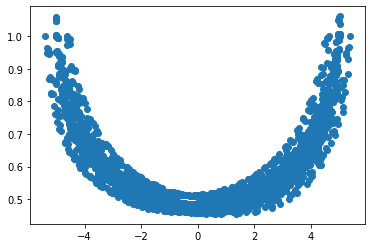

In [28]:
fig ,ax = plt.subplots()
ax.plot(follicle.face_df["z"], follicle.face_df["contractile_grad"], "o")

In [30]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [31]:
import ipywidgets as widgets
from IPython.display import display

In [32]:
class MonolayerView(widgets.HBox):
    
    def __init__(self, eptm):
        
        plt.ioff()
        ipv.clear()
        self.fig3D, self.mesh = sheet_view(follicle, mode="3D", **draw_specs);
        self.graph_widget = widgets.Output()
        with self.graph_widget:
            
            self.fig2D, (self.ax0, self.ax1) = plt.subplots(2, 1, sharey=True, sharex=True)

            _ = sheet_view(
                follicle.get_sub_sheet('apical'),
                mode="2D", coords=["z", "x"],
                ax=self.ax0,
                **draw_specs
            )
            _ = sheet_view(
                follicle.get_sub_sheet('basal'),
                mode="2D",
                coords=["z", "x"],
                ax=self.ax1,
            )
            self.ax0.set_title('Apical mesh')
            self.ax1.set_title('Basal mesh')
            self.fig2D.savefig("../doc/elongated0.png", dpi=300)
            self.fig2D.set_size_inches(5, 8)
            plt.close(self.fig2D)
            display(self.fig2D)
            
        super().__init__([self.fig3D, self.graph_widget])
        
        

In [33]:
MonolayerView(follicle)

MonolayerView(children=(Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0…

In [34]:

ipv.clear()
follicle.face_df.loc[follicle.lateral_faces, 'visible'] = False
follicle.face_df.loc[follicle.basal_faces, 'visible'] = False
follicle.face_df.loc[follicle.apical_faces, 'visible'] = True

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

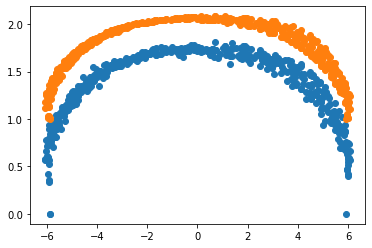

In [35]:
fig, ax = plt.subplots()

ax.plot(follicle.cell_df['z'], follicle.cell_df['vol'], "o")
ax.plot(follicle.cell_df['z'], follicle.cell_df['prefered_vol'], "o")


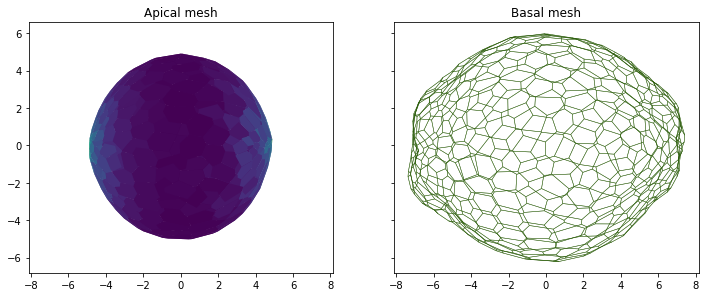

In [36]:

fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, sharex=True)

fig, ax0 = sheet_view(
    follicle.get_sub_sheet('apical'),
    mode="2D", coords=["z", "x"],
    ax=ax0,
    **draw_specs
)
fig, ax1 = sheet_view(
    follicle.get_sub_sheet('basal'),
    mode="2D",
    coords=["z", "x"],
    ax=ax1,

)


ax0.set_title('Apical mesh')

ax1.set_title('Basal mesh')
fig.savefig("../doc/elongated0.png", dpi=300)
fig.set_size_inches(12, 8)

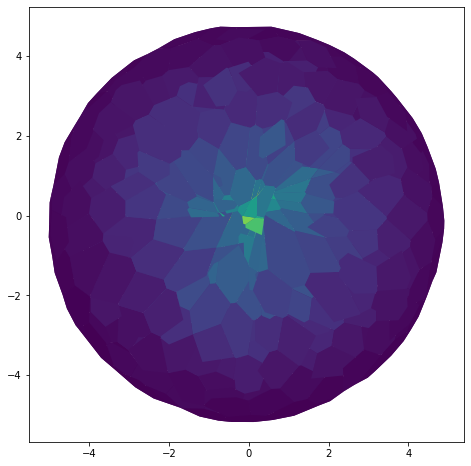

In [37]:
basal_s = follicle.get_sub_sheet('apical')
basal_s.reset_index()
fig, ax = sheet_view(basal_s, mode="2D", coords=["x", "y"], **draw_specs)


fig.set_size_inches(8, 8)


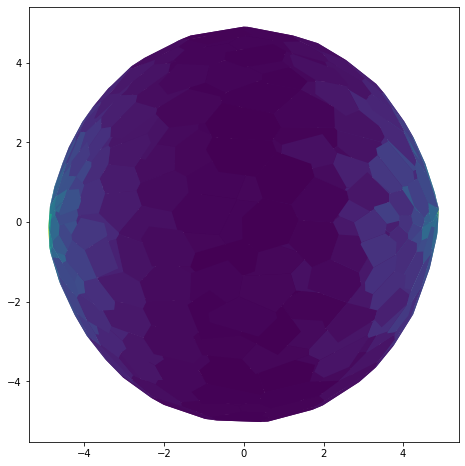

In [38]:
basal_s = follicle.get_sub_sheet('apical')
basal_s.reset_index()
fig, ax = sheet_view(basal_s, mode="2D", coords=["z", "x"], **draw_specs)


fig.set_size_inches(8, 8)


### Increasing lumen volume





In [95]:
follicle.settings['lumen_prefered_vol'] *= 1.5


In [96]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [97]:

ipv.clear()

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

## Cell division and dynamic model

$$
\ln(V_\mathrm{lum})(t) = a + k_V t\\
V_\mathrm{lum}(t) = V_0 e^{k_V t}
$$



In [39]:
bck1 = follicle

In [61]:
follicle = bck1

# We take the time unit as 1/100th of a development stage

dt = 1e-2

default_division_spec = {
    "cell": -1,
    "growth_rate": 0.014,
    "critical_vol": 2.,
    "autonomous": True,
}

follicle.update_specs(
    {'settings':
     {
        "threshold_length": 1e-1,  # Critical length to trigger rearangements
        "p_4": 1.,  ## Frequency of rearangements
        "p_5+": 0.1,
    },
    'vert': {
        "viscosity": 0.1
    },
    'edge': {
        'is_valid': 1,
    }
})



# This will go in tyssue in the next release
@cell_lookup
def division(mono, manager, **kwargs):
    """Cell division happens through cell growth up to a critical volume,
    followed by actual division of the cell.
    
    Parameters
    ----------
    mono : a `Monolayer` instance
    manager : an `EventManager` instance
    cell_id : int,
      index of the mother cell
    growth_rate : float, default 0.1
      rate of increase of the prefered volume
    critical_vol : float, default 2.
      volume at which the cells stops to grow and devides
    """
    division_spec = default_division_spec
    division_spec.update(**kwargs)

    cell = division_spec["cell"]
    Vc = division_spec["critical_vol"] * mono.specs["cell"]["prefered_vol"]
    if mono.cell_df.loc[cell, "vol"] < Vc:
        dv = 1+division_spec["growth_rate"]*mono.settings['dt']
        da = dv**(1/3)
        increase(
            mono,
            'cell',
            cell,
            dv,
            "prefered_vol"
        )
        manager.append(division, **division_spec)
    else:
        print(f'division of cell {cell}')
        mono.cell_df.loc[cell, "prefered_vol"] = mono.specs["cell"]["prefered_vol"]
        daughter = cell_division(mono, cell, 'vertical')
        daughter_id = mono.cell_df.id.max() + 1
        mono.cell_df.loc[daughter, "id"] = daughter_id
        if division_spec["autonomous"]:
            manager.append(division, **division_spec)
            division_spec['cell_id'] = daughter_id
            manager.append(division, **division_spec)
            
            
def lumen_growth(mono, manager, **kwargs):
    
    growth_rate = 0.02# kwargs.get('growth_rate', 0.014)
    dt = mono.settings["dt"]
    mono.settings['lumen_prefered_vol'] *= 1 + growth_rate*dt
    manager.append(lumen_growth, **kwargs)
    

base_dir = Path("../data")
time_stamp = datetime.today().strftime("%y-%m-%d-%H-%M-%S")
history_file = Path(f"hist2D_{time_stamp}.hf5")


follicle.cell_df['id'] = follicle.cell_df.index.copy()

# Copy the initial follicle
eptm = follicle.copy()

eptm.edge_df[['srce', 'trgt']] = eptm.edge_df[['srce', 'trgt']].astype(int)

eptm.settings["dt"] = dt

manager = EventManager("cell")
# Auto solve rearangements
manager.append(reconnect)

for cell_id in eptm.cell_df['id']:
    manager.append(division, cell_id=cell_id)

manager.append(lumen_growth, growth_rate=1.4e-2)


history = HistoryHdf5(
    eptm,
    save_every=0.1,
    dt=dt,
    hf5file=base_dir / history_file,
    extra_cols={
        elem: list(follicle.datasets[elem].columns) for elem in follicle.datasets
    },  # record everything
)

solver = EulerSolver(
    eptm,
    geom,
    model,
    manager=manager,
    history=history,
    bounds=(
        -eptm.edge_df.length.median(),
        eptm.edge_df.length.median(),
    ),
)

manager.update()


In [57]:
print(eptm.settings['lumen_prefered_vol'])

549.4505494505496


In [60]:
%pdb

Automatic pdb calling has been turned ON


In [62]:
solver.solve(10, dt)
print(eptm.settings['lumen_prefered_vol'])

ValueError: There is a change of datatype in cell table in {'num_faces': dtype('int64'), 'num_ridges': dtype('int64')} columns

> /home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.7.1-py3.7-linux-x86_64.egg/tyssue/core/history.py(358)record()
    356                     raise ValueError(
    357                         "There is a change of datatype in {} table in {} columns".format(
--> 358                             element, changed_type
    359                         )
    360                     )

ipdb> u
> /home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.7.1-py3.7-linux-x86_64.egg/tyssue/solvers/viscous.py(107)record()
    105 
    106     def record(self, t):
--> 107         self.history.record(time_stamp=t)
    108 
    109     def solve(self, tf, dt, on_topo_change=None, topo_change_args=()):

ipdb> p t
0.0
ipdb> c


In [40]:
!mkdir ../data

In [ ]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}


browse_history(solver.history, **draw_specs)

In [44]:
QSSolver().find_energy_min(eptm, geom, model)

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.7.0-py3.7-linux-x86_64.egg/tyssue/geometry/bulk_geometry.py:106: RuntimeWarning: invalid value encountered in true_divide
  weighted_pos.values / eptm.face_df["perimeter"].values[:, np.newaxis]


      fun: nan
 hess_inv: <4380x4380 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.36690551e+199, -3.06742022e+199,  3.20848995e+199, ...,
       -1.23593356e+199,  2.69866482e+198,  9.47243972e+198])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 21
      nit: 0
   status: 2
  success: False
        x: array([-0.74876237,  0.77660726,  2.84950127, ...,  4.22239187,
       -2.11316024, -0.104596  ])